In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from math import sqrt

from IPython.display import clear_output
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
# from torchvision import transforms

from sklearn.metrics import mean_squared_error as MSE_sklearn
MSE_torch = torch.nn.MSELoss()

In [2]:
df = pd.read_csv('all_data_Moscow_mean_T.csv')
df.head()

,Unnamed: 0,date,T
0,0,20151201,272.237556
1,1,20151202,270.353706
2,2,20151203,270.480820
3,3,20151204,272.624268
4,4,20151205,274.647697


In [3]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12)

T = df['T'].values - 273.15

# scaler = MinMaxScaler(feature_range=(-1, 1))
# T_size = T.size
# T = scaler.fit_transform(T.reshape(-1, 1)).reshape(T_size)
# plt.plot(T)

Populating the interactive namespace from numpy and matplotlib


C:\Python\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
train = T[:600].astype('Float32')
test = T[:].astype('Float32')

C:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  """Entry point for launching an IPython kernel.
C:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  


In [5]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        dataX.append(dataset[i: (i + look_back)])
        dataY.append(dataset[i + look_back])
    return torch.tensor(np.array(dataX)), torch.tensor(np.array(dataY))

In [6]:
def create_dataset_test(dataset, look_back, start):
    dataX, dataY = [], []
    for i in range(start, dataset.size):
        dataX.append(dataset[i - look_back: i])
        dataY.append(dataset[i])
    return torch.tensor(np.array(dataX)), torch.tensor(np.array(dataY))

In [7]:
look_back = 180

In [8]:
# 180 - 120 - 60 - 30 -15 Sigmoid 300 steps
hidden_1 = 120
hidden_2 = 60
hidden_3 = 30
hidden_4 = 15
# hidden_5 = 15

In [9]:
model = torch.nn.Sequential(torch.nn.Linear(look_back, hidden_1),
                            torch.nn.Sigmoid(),
                            torch.nn.Linear(hidden_1, hidden_2),
                            torch.nn.Sigmoid(),
                            torch.nn.Linear(hidden_2, hidden_3),
                            torch.nn.Sigmoid(),
                            torch.nn.Linear(hidden_3, hidden_4),
#                             torch.nn.Sigmoid(),  
#                             torch.nn.Linear(hidden_4, hidden_5),
                            torch.nn.Sigmoid(),                              
                            torch.nn.Linear(hidden_4, 1)
                            ).to(torch.device('cpu'))
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
        
model.apply(init_weights)        

C:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app


Sequential(
  (0): Linear(in_features=180, out_features=120, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=120, out_features=60, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=60, out_features=30, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=30, out_features=15, bias=True)
  (7): Sigmoid()
  (8): Linear(in_features=15, out_features=1, bias=True)
)

In [10]:
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset_test(test, look_back, 600)

23.192854


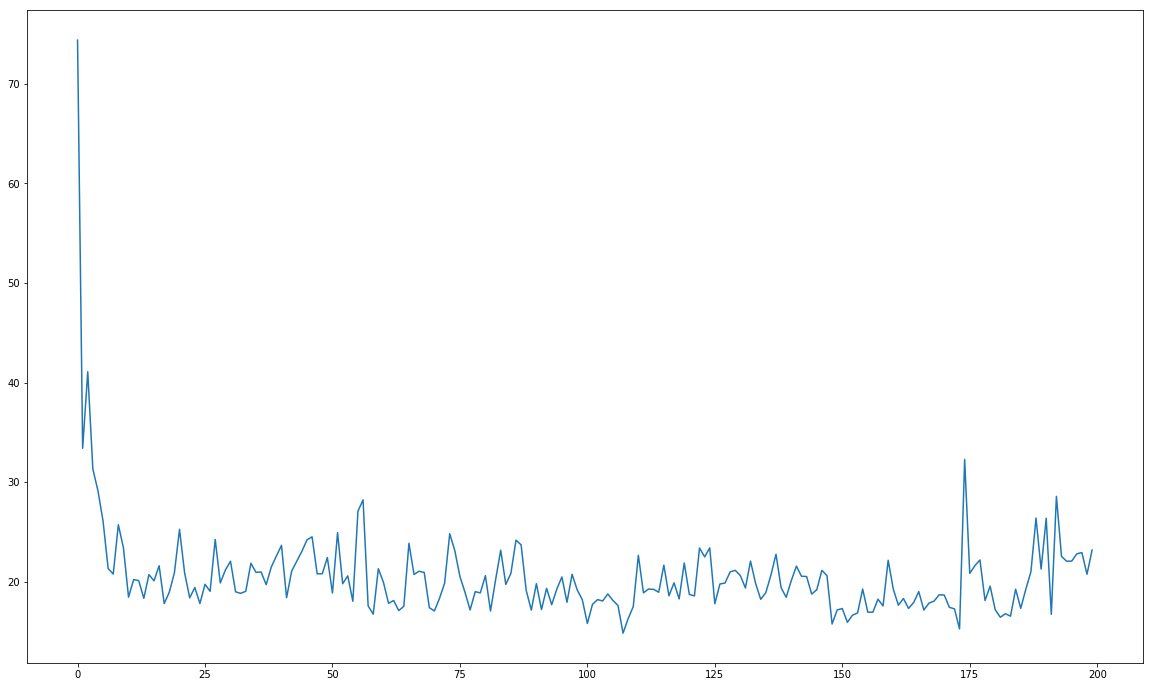

In [11]:
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []
for _ in range(200):
    losses_tmp = []
    for x, y in zip(trainX, trainY):
        y_pred = model.forward(x)
        loss = MSE_torch.forward(y_pred, y)
        losses_tmp.append(loss.data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(np.mean(losses_tmp))
    clear_output(True)
    print(np.mean(losses_tmp))
    plt.plot(losses)
    plt.show()

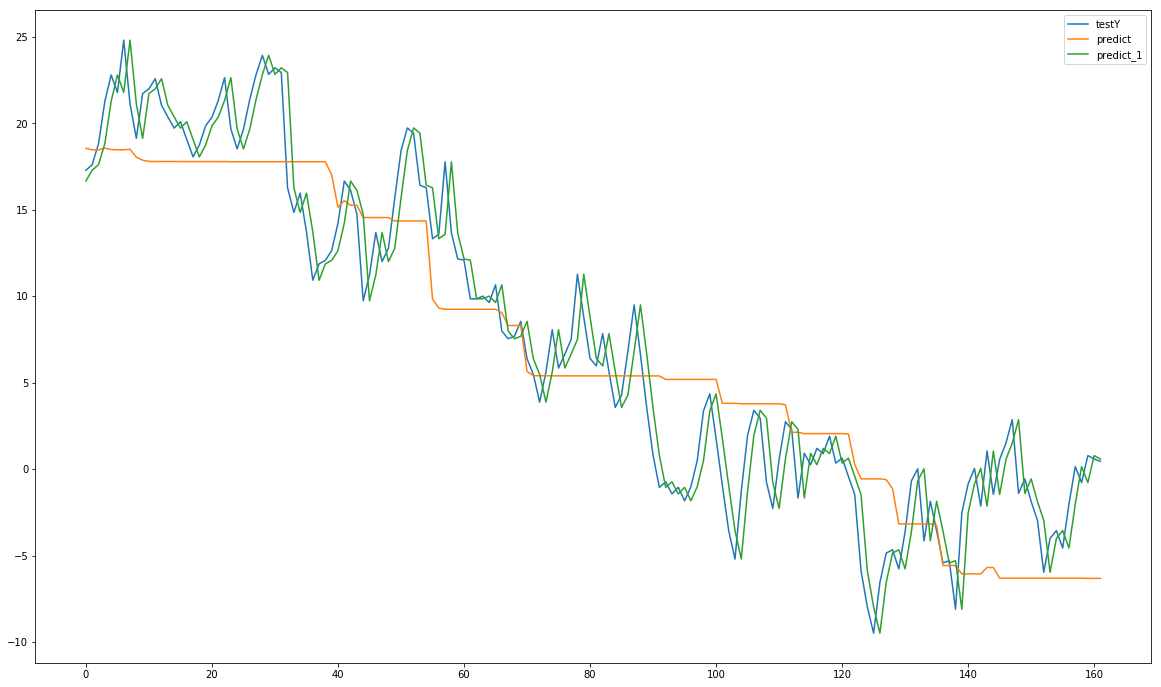

In [12]:
trainX_ten = torch.Tensor(trainX)
predict = []
predict_1 = []
for x in testX:
    pred = model(x)
    predict.append(pred)
    predict_1.append(x[-1])
plt.plot(testY.data.tolist(), label='testY')
plt.plot(predict, label='predict')
plt.plot(predict_1, label='predict_1')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error as MSE
print('model {}'.format(MSE_sklearn(predict, testY.data.tolist())))
print('baseline {}'.format(MSE_sklearn(predict_1, testY.data.tolist())))

model 15.224075334270102
baseline 4.334666719040267


### Long-term predict

In [ ]:
start = 600

In [14]:
pred = []
X = testX[0]
predict = model(X)
pred.append(predict.detach().item())
testY = np.array(T[start:])
for _ in range(testY.size - 1):
#     X = X.reshape(30)
    X = np.append(X[1:], predict.detach().numpy())
    predict = model(torch.tensor([X]))
    pred.append(predict.detach().item())

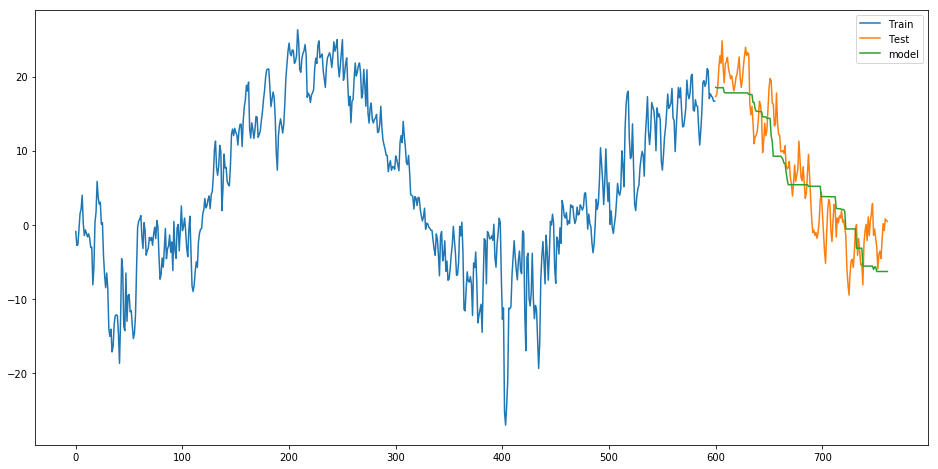

In [15]:
plt.figure(figsize=(16,8))
plt.plot(train, label='Train')
plt.plot(range(start, 762), testY, label='Test')
plt.plot(range(start, 762), pred, label='model')
plt.legend(loc='best')
plt.show()

In [16]:
MSE_sklearn(pred, testY)

15.260368556441055

In [28]:
start = 500

In [29]:
testX, testY = create_dataset_test(test, look_back, start)

In [30]:
pred = []
X = testX[0]
predict = model(X)
pred.append(predict.detach().item())
testY = np.array(T[start:])
for _ in range(testY.size - 1):
#     X = X.reshape(30)
    X = np.append(X[1:], predict.detach().numpy())
    predict = model(torch.tensor([X]))
    pred.append(predict.detach().item())

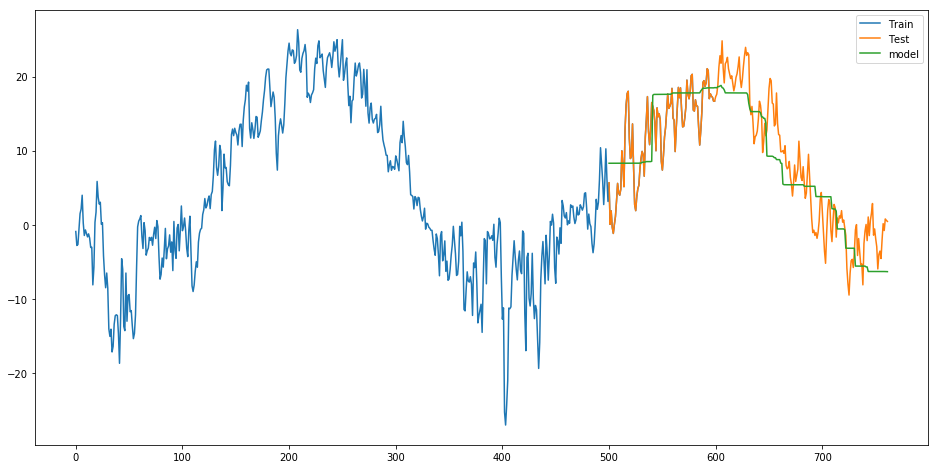

In [31]:
plt.figure(figsize=(16,8))
plt.plot(train, label='Train')
plt.plot(range(start, 762), testY, label='Test')
plt.plot(range(start, 762), pred, label='model')
plt.legend(loc='best')
plt.show()

In [32]:
MSE_sklearn(pred, testY)

17.494081587304798

In [38]:
start = 600

In [39]:
pred = []
X = testX[0]
predict = model(X)
pred.append(predict.detach().item())
testY = np.array(T[start:])
for _ in range(1000):
#     X = X.reshape(30)
    X = np.append(X[1:], predict.detach().numpy())
    predict = model(torch.tensor([X]))
    pred.append(predict.detach().item())

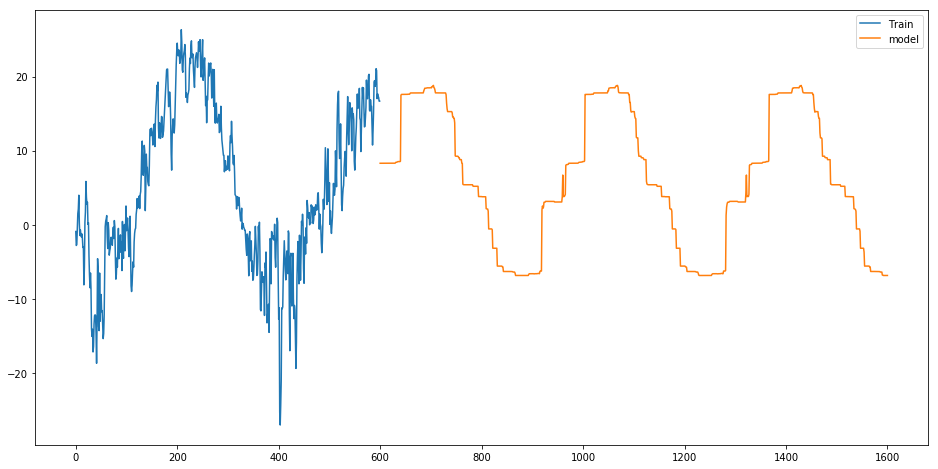

In [40]:
plt.figure(figsize=(16,8))
plt.plot(train, label='Train')
# plt.plot(range(start, start + 501), testY, label='Test')
plt.plot(range(start, start + 1001), pred, label='model')
plt.legend(loc='best')
plt.show()